In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax.numpy as np
from jax import jit
import matplotlib.pyplot as plt
import pandas as pd
from descartes import PolygonPatch
from gzbuilder_analysis.aggregation import make_ellipse
from gzbuilder_analysis.aggregation.spirals.utils import xy_from_r_theta
from gzbuilder_analysis.aggregation.spirals.deprojecting import reproject_arm
from gzbuilder_analysis.rendering.jax import fit
from jax.config import config
config.update("jax_enable_x64", True)

In [3]:
subject_id = 20902011

In [4]:
fitting_metadata = pd.read_pickle('lib/fitting_metadata.pkl')\
    .loc[subject_id]
data = fitting_metadata.galaxy_data
psf = fitting_metadata.psf
sigma_image = fitting_metadata.sigma_image

In [5]:
agg_res = pd.read_pickle(f'output_files/aggregation_results/{subject_id}.pkl.gz')

In [6]:
arm = agg_res.spiral_arms[0]

In [7]:
def get_params(arm):
    t = arm.t_predict
    a, b = arm.logsp_model.named_steps['bayesianridge'].regressor_.coef_
    A = np.exp(a) * arm.image_size[0]
    phi = np.rad2deg(np.arctan(b))
    return A, phi

/Users/tlingard/anaconda3/lib/python3.6/site-packages/jax/lib/xla_bridge.py:119: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


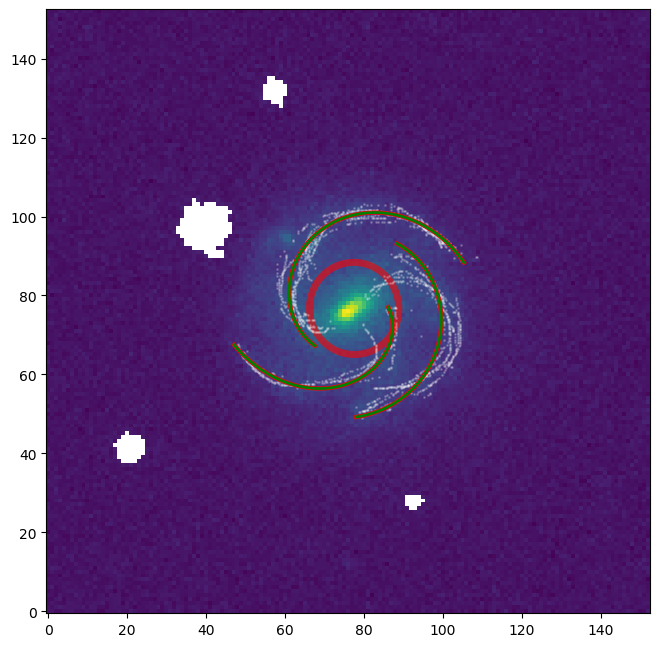

In [8]:
plt.figure(figsize=(8, 8), dpi=100)
plt.imshow(data, origin='lower')
plt.gca().add_patch(PolygonPatch(make_ellipse(agg_res.params['disk'].to_dict()), fc='none', ec='r', lw=5, alpha=0.6))
for a in agg_res.spiral_arms:
    plt.plot(*a.coords[a.outlier_mask].T, '.', c='w', ms=2, alpha=0.2)
    plt.plot(*a.reprojected_log_spiral.T, c='r', lw=3)
for a in agg_res.spiral_arms:
    tmin = a.t_predict.min()
    tmax = a.t_predict.max()
    plt.plot(*fit.log_spiral(tmin, tmax, a.A, a.pa * a.chirality, **agg_res.params['disk']).T, lw=2, c='g')

In [9]:
arm.pa, arm.sigma_pa

(12.8311468655505, 0.000796984904136773)

(39.57226658952209, 115.49151642622799, 69.02196672920898, 84.40671326250968)

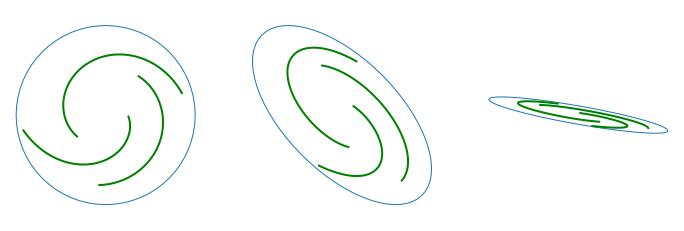

In [10]:
new_disk = agg_res.params['disk'].copy()
new_disk['q'] = 1
new_disk['Re'] *= 3
new_disk['roll'] = 0
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.gca().add_patch(PolygonPatch(make_ellipse(new_disk.to_dict()), fc='none', ec='C0'))
for a in agg_res.spiral_arms:
    A, phi = get_params(a)
    plt.plot(*fit.log_spiral(
        a.t_predict.min(),
        a.t_predict.max(),
        a.A, a.pa * a.chirality, **new_disk).T, lw=2, c='g')
plt.axis('equal')
plt.axis('off')

new_disk = agg_res.params['disk'].copy()
new_disk['q'] = 0.5b
new_disk['Re'] *= 3
new_disk['roll'] = np.deg2rad(45)
plt.subplot(132)
plt.gca().add_patch(PolygonPatch(make_ellipse(new_disk.to_dict()), fc='none', ec='C0'))
for a in agg_res.spiral_arms:
    A, phi = get_params(a)
    plt.plot(*fit.log_spiral(
            a.t_predict.min(),
        a.t_predict.max(),
            a.A, a.pa * a.chirality, **new_disk).T, lw=2, c='g')
plt.axis('equal')
plt.axis('off')

new_disk = agg_res.params['disk'].copy()
new_disk['q'] = 0.1
new_disk['Re'] *= 3
new_disk['roll'] = np.deg2rad(80)
plt.subplot(133)
plt.gca().add_patch(PolygonPatch(make_ellipse(new_disk.to_dict()), fc='none', ec='C0'))
for a in agg_res.spiral_arms:
    A, phi = get_params(a)
    plt.plot(*fit.log_spiral(
        a.t_predict.min(),
        a.t_predict.max(),
        a.A, a.pa * a.chirality, **new_disk).T, lw=2, c='g')
plt.axis('equal')
plt.axis('off')

In [13]:
a%timeit fit.log_spiral(0, 2*np.pi, a.A, a.pa, new_disk['q'], new_disk['roll'], new_disk['mux'], new_disk['muy'], N=200)

1.02 ms ± 163 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
